In [1]:
import os
import re
import boto3
import itertools
import json
import inspect


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sagemaker.session import Session
from joblib import dump, load

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.cluster import AffinityPropagation, KMeans, AgglomerativeClustering

In [3]:
from sklearn.decomposition import LatentDirichletAllocation

In [4]:
from sklearn.metrics import confusion_matrix, precision_score, classification_report
from sklearn.preprocessing import LabelEncoder

from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold, KFold

## Helper Functions & Classes

In [5]:
# small class for holding "special" print flags
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

## Interact with System Environment

In [6]:
# initiate s3 bucket and corresponding data folder
bucket = "ran-s3-systemic-risk"
data_folder ="Output/BalanceSheet/"

# Amazon Textract client and Sagemaker session
textract = boto3.client('textract')
s3 = boto3.client('s3')
session = Session()

# discover all of the pdfs that you want to parse
paths = np.array(session.list_s3_files(bucket, data_folder))

## Line Item Label Clustering
**Using KMeans clustering for determing word similitaries amongst balance sheet items**

In [325]:
def word_matching(array: np.array, vectorizer_class, cluster_class) -> tuple:
    
    # Convert a collection of text documents to a matrix of token counts
    vectorizer = vectorizer_class
    print('Using the {} text vectorizer\n'.format(type(vectorizer_class).__name__))
    
    # produces a sparse representation of the counts using scipy.sparse.csr_matrix.
    X = vectorizer.fit_transform(array)
    
    # initialize the clustering model on words
    model = cluster_class
    
    model.fit(X)  # fit clustering model to array of strings

    # returns dataframe, mapping cluster labels to line items
    outDF = pd.DataFrame({'Labels': model.labels_, 'LineItems': array})
    
    print('\n{} clusters were found using {} algorithm'.format(model.labels_.max()+1, type(cluster_class).__name__))
    
    return model.labels_, model.cluster_centers_, outDF 

In [322]:
# reading cleaned unstructured data sets for samples 
assets = pd.read_csv('unstructAssetSample.csv')
liability = pd.read_csv('unstructLiableSample.csv')

**The following clustering model specifications are outlined below:**

- **array:** We select the columns from either asset or liability tables, not including CIK or Year components.
- **vectorizer_class:** We implement a standard TfidVectorizer class, converting the collection of strings to a matrix of TF-IDF features.

- **cluster_class:** We fit a KMeans clustering algorithm, employing **35 cluster** using the the classic **expectation–maximization algorithm (full)** for computing the KMeans clusters with **25 centroid seeds** to check against. We also control the random state and provided verbosity to model fits

In [323]:
clusters = 35
text_vectorizer = TfidfVectorizer(lowercase=True)
cluster_mdl = KMeans(n_clusters=clusters, n_init=25, verbose=1, random_state=1, algorithm='full')

In [326]:
# perform clustering on the asset line items
assetTerms = assets.columns.values[2:]
np.random.shuffle(assetTerms)

# divide asset terms into in and out of sample categories
insAssets = assetTerms[:-50]
outAssets = assetTerms[-50:]
assetlabel, assetCenters, df1 = word_matching(array = insAssets, vectorizer_class = text_vectorizer, 
                                              cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration  0, inertia 1624.657
Iteration  1, inertia 1005.032
Iteration  2, inertia 990.180
Iteration  3, inertia 980.462
Iteration  4, inertia 966.366
Iteration  5, inertia 961.780
Iteration  6, inertia 960.659
Iteration  7, inertia 960.191
Iteration  8, inertia 960.120
Converged at iteration 8: center shift 0.000000e+00 within tolerance 9.230354e-08
Initialization complete
Iteration  0, inertia 1583.349
Iteration  1, inertia 974.822
Iteration  2, inertia 955.365
Iteration  3, inertia 949.074
Iteration  4, inertia 946.936
Iteration  5, inertia 944.896
Iteration  6, inertia 941.786
Iteration  7, inertia 941.457
Iteration  8, inertia 941.185
Iteration  9, inertia 940.804
Iteration 10, inertia 940.525
Iteration 11, inertia 940.297
Iteration 12, inertia 940.214
Iteration 13, inertia 939.833
Iteration 14, inertia 939.557
Iteration 15, inertia 938.935
Iteration 16, inertia 938.045
Iteration 17, inertia 937.748
Iteration 18, 

Iteration  0, inertia 1583.618
Iteration  1, inertia 964.989
Iteration  2, inertia 947.455
Iteration  3, inertia 941.901
Iteration  4, inertia 937.829
Iteration  5, inertia 935.415
Iteration  6, inertia 934.694
Iteration  7, inertia 933.918
Iteration  8, inertia 933.399
Iteration  9, inertia 932.292
Iteration 10, inertia 930.946
Iteration 11, inertia 930.817
Converged at iteration 11: center shift 0.000000e+00 within tolerance 9.230354e-08
Initialization complete
Iteration  0, inertia 1572.299
Iteration  1, inertia 981.429
Iteration  2, inertia 964.311
Iteration  3, inertia 958.627
Iteration  4, inertia 956.469
Iteration  5, inertia 955.237
Iteration  6, inertia 955.023
Iteration  7, inertia 954.947
Iteration  8, inertia 954.905
Converged at iteration 8: center shift 0.000000e+00 within tolerance 9.230354e-08
Initialization complete
Iteration  0, inertia 1561.839
Iteration  1, inertia 960.291
Iteration  2, inertia 939.555
Iteration  3, inertia 929.936
Iteration  4, inertia 928.567
Iter

In [327]:
# perform clustering on the liability & equity line items
liabilityTerms = liability.columns.values[2:]
np.random.shuffle(liabilityTerms)

# divide liability terms into in and out of sample categories
insLiability = liabilityTerms[:-50]
outLiability = liabilityTerms[-50:]

liabilitylabel, liabilityCenters, df2 = word_matching(array = insLiability, vectorizer_class = text_vectorizer, 
                                                      cluster_class = cluster_mdl)

Using the TfidfVectorizer text vectorizer

Initialization complete
Iteration  0, inertia 950.963
Iteration  1, inertia 610.627
Iteration  2, inertia 587.552
Iteration  3, inertia 578.859
Iteration  4, inertia 574.915
Iteration  5, inertia 573.604
Iteration  6, inertia 573.234
Iteration  7, inertia 573.055
Iteration  8, inertia 573.000
Converged at iteration 8: center shift 0.000000e+00 within tolerance 1.660587e-07
Initialization complete
Iteration  0, inertia 949.652
Iteration  1, inertia 600.915
Iteration  2, inertia 585.608
Iteration  3, inertia 579.960
Iteration  4, inertia 578.548
Iteration  5, inertia 578.336
Iteration  6, inertia 578.252
Iteration  7, inertia 578.198
Iteration  8, inertia 578.139
Converged at iteration 8: center shift 0.000000e+00 within tolerance 1.660587e-07
Initialization complete
Iteration  0, inertia 928.490
Iteration  1, inertia 599.238
Iteration  2, inertia 585.589
Iteration  3, inertia 576.027
Iteration  4, inertia 570.369
Iteration  5, inertia 566.225
I

Iteration  0, inertia 913.278
Iteration  1, inertia 598.276
Iteration  2, inertia 577.906
Iteration  3, inertia 571.298
Iteration  4, inertia 569.223
Iteration  5, inertia 568.330
Iteration  6, inertia 567.782
Iteration  7, inertia 567.327
Iteration  8, inertia 567.182
Iteration  9, inertia 567.135
Converged at iteration 9: center shift 0.000000e+00 within tolerance 1.660587e-07
Initialization complete
Iteration  0, inertia 943.462
Iteration  1, inertia 591.682
Iteration  2, inertia 574.016
Iteration  3, inertia 569.087
Iteration  4, inertia 567.431
Iteration  5, inertia 567.368
Iteration  6, inertia 567.109
Iteration  7, inertia 566.868
Iteration  8, inertia 566.749
Iteration  9, inertia 566.711
Converged at iteration 9: center shift 0.000000e+00 within tolerance 1.660587e-07
Initialization complete
Iteration  0, inertia 948.753
Iteration  1, inertia 590.756
Iteration  2, inertia 569.328
Iteration  3, inertia 563.397
Iteration  4, inertia 561.246
Iteration  5, inertia 560.992
Iteratio

### Examination of Clusters Realiablity
**Observing the distance between cluster centroids, tracking numerical difference relative to other labels**

In [42]:
def distance_matrix(centers: np.ndarray):
    clusters, nfeatures  = centers.shape
    itRange = np.arange(clusters)
    
    # similar to covariance matrix, initialize memory for distance matrix
    dMat = np.zeros((clusters, clusters))
    
    for i in itRange:
        for j in itRange:
            # computing the distance between centroids to examine label closeness
            distance = np.sqrt(np.sum(np.square(centers[i, :] - centers[j, :])))
            
            # assign values to the corresponding distance matrix
            dMat[i, j] = distance
    
    return dMat

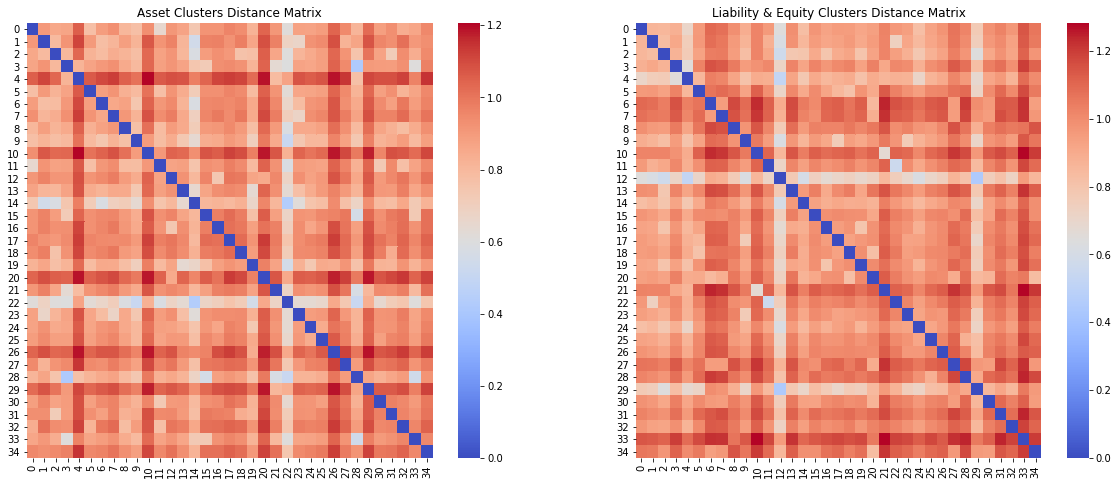

In [43]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(20)
fig.set_figheight(8)
sns.heatmap(distance_matrix(assetCenters), cmap='coolwarm', ax=axes[0])
sns.heatmap(distance_matrix(liabilityCenters), cmap='coolwarm', ax=axes[1])
axes[0].set_title('Asset Clusters Distance Matrix')
axes[1].set_title('Liability & Equity Clusters Distance Matrix')
plt.show()

Clustering works to great effect with the vast majority of cases presented, but there still appears to be issues that persist when trying to divide the current dataset - namely more nuanced differences such as "Total Liabilites and Equity" and "Total Equity". I want to try grouping these and then clustering them again.

As exhbited, repeated clustering on a smaller subset of line items does not break it into expected groups. Rather, we arrive at similar breaks that we saw before when using a smaller KMeans cluster set. Hence, I will pursue the LDA as is, and see the label identificaition that follows.

## Latent Dirichlet Allocation with online variational Bayes algorithm
**A Topic Model for root-word detection from a list of similar strings** 

Our goal here is to determine whether using LDA decomposition is useful in determining label names for clustering classes

* The corpus is a collection of **D** documents, which will be a cluster with corresponding word groupings from KMeans
* A document is a sequence of **N** words, which corresponds to the sequence of characters of each word in the cluster
* There are **K** topics in the corpus, which will be one as we are looking to determine roots

In [24]:
def label_LDA(names, LDA_model):
    assert type(LDA_model).__name__ is 'LatentDirichletAllocation', 'Model restriction, only imposed LDA'
    
    print('Clustered names provided are:\n\n', names, '\n')
    labelNames = []
    
    # vectorize the text (string) data to be used by Latent Dirichlet Allocation algorithm
    text_mdl = TfidfVectorizer()
    vec_text = text_mdl.fit_transform(names)
    
    # feature names extracted from the TfidVectorizer
    feature_names = text_mdl.get_feature_names()
  
    # fit Laten Dirichlet Allocation model 
    mdl = LDA_model
    mdl.fit(vec_text)
    
    print()
    # print out label names determined from LDA
    for topic in mdl.components_:
        message = "Topic determined: "
        message += " ".join([feature_names[i]
                             # select the 5 most important feature names from largest to smallest order
                             for i in topic.argsort()[:-5 - 1:-1]])
        print(color.BOLD, message, color.END)
        labelNames.append(message)
    print()
    
    return labelNames

Continuing this current assesment of topic detection, we extend this to the entire subset of items computed from the clustering algorithm employed to group each of the asset/liability line items grouped before. **(Refer to KMeans Model for details on clustering)**


In [26]:
# creating names for liability line clusters
for i in range(df2.Labels.max()+1):
    print('Label', i)
    cluster_cells = df2[df2.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['10,000 shares issued and outstanding; $1 stated value' 'and outstanding'
 '200 shares authorized - NPV 100 shares issued & outstanding'
 '1,200 shares issued and outstanding' '220 shares issued and outstanding'
 '1,000 Shares, Issued and Outstanding'
 'and 100 shares issued and outstanding' '1,000 shares issued'
 '6,300,000 shares issued and outstanding'
 'authorized, 100 shares issued and outstanding'
 'Shares, Issued 301 Shares, Outstanding 0 Shares'
 '805,000 shares issued and outstanding'
 'shares authorized, 1,000 shares issued'
 'authorized, 277,284 shares issued and outstanding'
 'issued and outstanding, at stated value'
 'Issued And Outstanding - 100 Shares' 'and outstanding 1000 shares'
 'authorized, 414,836 shares issued and outstanding'
 'Issued and outstanding 1,000 shares' '10 shares issued and outstanding)'
 'issued and outstanding, 100 shares'
 '1,000 Shares Authorized, Issued and Outstanding'
 'shares issued and outstanding'
 '


 Topic determined: accrued liabilities expenses and other 


Label 6

Clustered names provided are:

 ['Total lia bilities' 'Accrued 401k contribution' 'B. Secured'
 'See accompanying notes to financial statement.' 'Affiliates'
 'Financial instruments ow ned' 'Accrued product costs'
 'D. Undue concentration' 'Commercial paper'
 'Accrued profit sharing contribution'
 'Corporate debt and collateralized mortgage obligations'
 'Liabilites: Current liabilities' 'Line of credit'
 'The accompanying notes are an integral part of these financial'
 'A. Clearance account' 'Commitments, contingencies and guarantees'
 '1 common share' '6. Options' 'Bank loans and overdrafts'
 'Accrued commissions and clearance charges' 'Corporate and other debt'
 'Supplemental Financial Information' 'Contributions'
 'Contractual commitments' "Morgan Stanley & Co. LLC member's equity"
 'Distributions' 'Fails to Receive' 'Stocks, warrants, and options'
 'Stocks, warrants and options' 'at market value:'
 '71,965 shar

iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: yet sold purchased not securities 


Label 12

Clustered names provided are:

 ['17. Accounts payable, accrued liabilities, expenses and other'
 'Accounts Payable : Commissions'
 'Liabilities Accounts payable and accrued expenses'
 'Liabilities Accounts payable and accrued liabilities'
 'Accounts payable and other accrued liabilities'
 'Current liabilities Accounts payable and accrued expenses'
 'Accounts payable and Accrued Expenses Taxes Payable'
 'Accounts payable - commissions'
 'Accrued expenses and accounts payable Total Liabilities'
 'Accounts payable, accrued expenses and other liabilities'
 'accounts payable and accrued expenses' 'Accounts Payable'
 'Accounts payable - related party' 'Accounts payble and accrued expenses'
 'Accounts payable and accrued expenses'
 'Liabilities - Accounts payable and accrued expenses' 'Accounts payable'
 'Accou

iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: to broker payable dealer due 


Label 18

Clustered names provided are:

 ['Short-term borrowings (included $2,863 at fair value)'
 'Short-term borrowings' 'Short term borrowings (Note 6)'
 'Short-term borrowings (included $221 at fair value)'
 'Short term bonds and notes issued'
 'Unsecured short-term borrowings, including the current portion of unsecured long-term borrowings (includes $1,303,559 at fair value)'
 'Unsecured long-term borrowings (includes $347,904 at fair value)'
 'Borrowings' 'Liabilities: Short term borrowings (Note 6)'
 'Long-term debt (including $137 at fair value)'
 'Unsecured long-term borrowings (includes $146 at fair value)'
 'Unsecured short-term borrowings, including the current portion of unsecured long-term borrowings (includes $3 at fair value)'
 'Unsecured short-term borrowings, including the


 Topic determined: capital in paid additional partners 


Label 25

Clustered names provided are:

 ['Reverse conversion securities, at fair value'
 'Reverse conversion securities, at market value'
 'Deposits received for securities loaned'
 'Securities loaned (includes $4,964 at fair value)'
 'Securities loaned (includes fair value of $57)'
 'Securities loaned (includes $5,646 at fair value)'
 'Securities loaned (includes $14,642 at fair value)'
 'Securities loaned (includes $31,698 at fair value)'
 'Securities financing transactions: Securities sold under agreements to repurchase (includes securities at fair value of $80,267,928) Securities loaned (includes securities at fair value of $693,613)'
 'Securities financing transactions: Securities sold under agreements to repurchase (includes securities at fair value of $41,290,013) Securities loaned (includes securities at fair value of $155,881)'
 'Securities loaned (includes $7,483 at fair value)'
 'Securities loaned (includes $23,810

iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: note payable to notes stockholder 


Label 34

Clustered names provided are:

 ['TOTAL STOCKHOLDERS EQUITY' "Stockholders' equity"
 "Total liabilities and stockholders' equity" "Total stockholders' equity"
 "STOCKHOLDERS' EQUITY Capital Stock, at stated value,"
 "Total Liabilities and Stockholders' Equity"
 "Total Liabilities and stockholders' equity" "Total Stockholders' Equity"
 "TOTAL LIABILITIES & STOCKHOLDERS'"
 "TOTAL LIABILITIES AND STOCKHOLDERS' EQUITY"
 'TOTAL LIABILITIES AND STOCKHOLDERS EQUITY' "TOTAL STOCKHOLDERS' EQUITY"
 'Stockholders Equity'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iterati

In [28]:
df2.to_csv('liabilityLDA', index=False)

In [25]:
# creating names for assest line clusters
for i in range(df1.Labels.max()+1):
    print('Label', i)
    cluster_cells = df1[df1.Labels == i]['LineItems'].values
    print()
    _ = label_LDA(cluster_cells, 
                  LatentDirichletAllocation(n_components=1, verbose=1, random_state=1))
    print()

Label 0

Clustered names provided are:

 ['Cash and securities segregated in compliance with federal and other regulations'
 'Cash and securities segregated pursuant to federal and other regulations'
 'Cash and securities deposited with clearing organizations or segregated under federal and other regulations or requirements (including securities at fair value of'
 'Cash segregated pursuant to federal and other regulations'
 'Cash, securities and securities purchased under agreements to resell segregated in compliance with federal and other regulations'
 'Cash segregated pursuant to federal regulations'
 'Cash and securities deposited with clearing organizations or segregated under federal and other regulations (securities at fair value of $16,654,789)'
 'Cash and securities deposited with clearing organizations or segregated under federal and other regulations (securities at fair value of $34,763,381)'
 'Cash and securities segregated pursuant to federal and other regulations (Note 3)'

iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: receivable broker from dealer clearing 


Label 6

Clustered names provided are:

 ['Furniture, equipment and leasehold improvements, (net of accumulated depreciation and amortization of $1,464,902)'
 'Furniture and fixtures (cost of $2,226,634, net of $752,753 accumulated depreciation)'
 'Furniture, equipment, leasehold improvements and software, net (includes'
 'Property, equipment and leasehold improvements, at cost (less accumulated depreciation and amortization of $180,979) Other assets'
 'Property, equipment and leasehold improvements, net of accumulated depreciation and amortization of $208'
 'Property, equipment and leasehold improvements, at cost (less accumulated depreciation and amortization of $207,276) Other assets'
 'NET BUILDING, FURNITURE AND FIXTURES'
 'Furniture and equipment, net of accumulated depreciation of $105,572'
 'Property, equipment and leasehold impro

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: net of equipment property and 


Label 9

Clustered names provided are:

 ['Cash and securities segregated for regulatory and other purposes (includes $63,394 at fair value)'
 'Cash and securities segregated for benefit of customers (includes securities at fair value of $7,901)'
 'Cash and securities segregated for benefit of customers'
 'Cash and securities segregated for regulatory and other purposes (includes $81,619,815 at fair value)'
 'Cash and securities segregated for benefit of customers (includes securities at fair value of $7,862)'
 'Cash and securities segregated for benefit of customers (includes securities at fair value of $7,338)'
 'Cash and securities segregated fo

iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: payable loan advances to employee 


Label 14

Clustered names provided are:

 ['Receivable from noncustomer' 'Commission receivable'
 'Receivable from customers, net'
 'Commissions receivable - net of reserves of $414'
 'Accrued interest and dividends receivable' 'Receivable from brokers'
 'Fees receivable' 'Receivable from Parent, net' 'Interest receivable'
 'Accrued interest receivable' 'Receivable from affiliates (Note 6)'
 'Commissions and fees receivable' 'Loan Receivable' 'Dividend receivable'
 'COMMISSIONS RECEIVABLE' 'Receivable from Others'
 'Insurance commissions receivable' 'Notes receivable (notes 3 and 4)'
 'Commissions Receivable - Clearing Corp.'
 'Notes receivable - related parties' 'Receivable from Non-Customer'
 'Loan Receivable - Employees' 'Investment advisory fees receivable'
 'Commissions receivable' 'Receivable from related par

 'Securities received as collateral, at fair value (included assets pledged of $1,912)'] 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: as collateral securities received pledged 


Label 21

Clustered names provided are:

 ['U.S. government agency securities owned, at market'
 'U.S. Government and agency obligations pledged as collateral'
 'U.S. government and government agency securities'
 'U.S. government and agency securities'
 'U.S. Government obligations pledged as collateral'
 'U.S. Government and agency obligations'
 'Non-U.S. government and government agency securities'
 'U.S. government and federal agency'
 'U.S. Treasury and federal agency securities'
 'Foreign government securities' 'Non-U.S. government and govern

iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: securities agreements under to value 


Label 26

Clustered names provided are:

 ['Deposits with and receivables from clearing broker' 'Time deposits'
 'Deposits with clearing organization' 'Deposits - clearing organizations'
 'Deposits received for securities loaned'
 'Deposits with clearing organizations and others' 'Deposits'
 'Deposits with exchanges and other segregated cash'
 'Deposits with clearing organizations' 'Deposits at clearing broker'
 'Clearing deposits'
 'Deposits paid for securities borrowed (including $50,553 at fair value)'
 'Deposits paid for securities borrowed (including $43,180 at fair value)'
 'Deposits paid for securities borrowed' 'Clearing firm deposits'
 'Deposits with clearing brokers' 'Deposits at clearing brokers'
 'Security deposits' 'Deposits with clearing organization (cash)'
 'Deposits with clearing firms'
 'Other 

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10

 Topic determined: of amortization and depreciation accumulated 


Label 32

Clustered names provided are:

 ['Federal Income Tax Payable' 'Income tax refund receivable'
 'Income tax receivable' 'Income taxes recoverable'
 'CURRENT LIABILITY, Income tax payable' 'Deferred income taxes'
 'Investment income receivable' 'Federal income taxes receivable'
 'Prepaid federal income tax' 'Deferred income taxes, net'
 'Increase in income taxes recoverable' 'Deferred Taxes - Federal'
 'Refundable Income Tax State' 'Prepaid State Income Tax' 'Net Income'
 'Prepaid federal and state taxes' 'Accrued income tax'
 'State Income Taxes Payable' 'State and Local Income Tax Receivable'
 'Refundable income taxes' 'Prep

In [29]:
df1.to_csv('assetLDA', index=False)

## Supervised Learning of Label Names
**Construct a classification model to match user defined categories to established balance sheet items**

In [31]:
# manualy assigning label names to corresponding cluster labels according to personal bias
assetlabelReplace = {
    0: "Cash and cash equivalents", 
    1: "Accumulated depreciation and amortization", 
    2: "Receivables from customers and counterparties",
    3: "Financial instruments owned, at fair value", 
    4: "Property, plant and equipment",
    5: "Receivable from broker-dealers",
    6: "Property, plant and equipment",
    7: "Other assets",
    8: "Property, plant and equipment",
    9: "Cash and securities segregated for benefit of customers",
    10: "Financial instruments owned, at fair value",
    11: "Due from counterparties",
    12: "Receivable from broker-dealers",
    13: "Loan advances to employee",
    14: 'Other receivables',
    15: "Deferred tax asset",
    16: "Financial instruments owned, at fair value",
    17: "Escrow account balances",
    18: "Exchange memberships",
    19: "Cash and cash equivalents",
    20: "Securities received as collateral",
    21: "U.S. government and government agency",
    22: "Financial instruments owned, at fair value",
    23: "Prepaid expenses and other assets",
    24: "Other assets", 
    25: "Reverse Repurchase Argreements (reverse-repo)",
    26: "Deposits with clearing organizations",
    27: "Deposits with clearing organizations",
    28: "Account receivable",
    29: "Total assets", 
    30: "Financial instruments owned, at fair value",
    31: "Accumulated depreciation and amortization", 
    32: "Other assets",
    33: "Fixed assets",
    34: "Other assets"
}

In [32]:
# first order change for cluster items
df1['classification'] = df1['Labels'].replace(assetlabelReplace)

In [36]:
# to deal with the overlaping "Total" components we filter these each by line item
assetlineReplace = {
    'Financial instruments sold under agreements to repurchase, at fair value': 'Repurchase Argreements (repo)',
    'Financial instruments sold, but not yet purchased, at fair value': "Securities sold short",
    'Note 4. Financial Instruments Owned and Financial Instruments Sold, But Not Yet Purchased': "Securities sold short",
    'Financial instruments sold, not yet purchased': "Securities sold short",
    'Financial instruments sold, not yet purchased,': "Securities sold short",
    'Financial instruments sold, not yet purchased, and': "Securities sold short",
    'Total financial instruments sold, not yet purchased, at fair value': "Securities sold short",
    'Less: Accumulated Depreciation':  "Accumulated depreciation and amortization",  
    'Accumulated Depreciation': "Accumulated depreciation and amortization", 
    'depreciation of $68,679)': "Accumulated depreciation and amortization", 
    'depreciation of $14,370': "Accumulated depreciation and amortization", 
    'depreciation of $7,591': "Accumulated depreciation and amortization", 
    'Accumulated depreciation': "Accumulated depreciation and amortization",
    'Accumulated Depreciation of $37,298': "Accumulated depreciation and amortization", 
    'Less Accumulated Depreciation': "Accumulated depreciation and amortization", 
    'Accumulated Depreciation of $37,138': "Accumulated depreciation and amortization", 
    'depreciation of $57,062': "Accumulated depreciation and amortization", 
    'Less: Accumulated depreciation': "Accumulated depreciation and amortization", 
    'accumulated depreciation of $190,428': "Accumulated depreciation and amortization", 
    'accumulated depreciation': "Accumulated depreciation and amortization", 
    'depreciation of $145,900)': "Accumulated depreciation and amortization", 
    'depreciation of $82,129)': "Accumulated depreciation and amortization", 
    'Less accumulated depreciation': "Accumulated depreciation and amortization", 
    'Receivables - other': 'Other receivables',
    'Other Receivables': 'Other receivables',
    'Accrued interest and dividend receivables': 'Other receivables', 
    'Trade receivables': 'Other receivables', 
    'Employee receivables': 'Other receivables', 
    'Customers': 'Other receivables', 
    'Branch receivables': 'Other receivables', 
    'Miscellaneous receivables': 'Other receivables',
    'Other receivables': 'Other receivables',
    'Other Non Current Receivables': 'Other receivables', 
    'Receivables from affiliates (Note 6)': 'Other receivables', 
    'Receivables:': 'Other receivables', 
    'Receivables-other': 'Other receivables',
    'Receivables': 'Other receivables', 
    'Receivables-othe:': 'Other receivables',
    'Accounts payable': 'Accounts payable', 
    'Accounts payable and Accrued Expenses': 'Accounts payable', 
    'Accounts Payable': 'Accounts payable', 
    'Taxes Payable': 'Accounts payable', 
    'Payable to broker Dealers, exchange': 'Accounts payable',  
    'Payroll taxes payable': 'Accounts payable', 
    'Payable to Affiliate': 'Accounts payable',  
    'State and Local Tax Payable': 'Accounts payable',
    'Accounts Payable - Commissions': 'Accounts payable',  
    'Payroll Taxes Payable': 'Accounts payable', 
    'Payable to affiliates' : 'Accounts payable', 
    'Clearing charges payable': 'Accounts payable', 
    'Dividends Payable': 'Accounts payable', 
    'Accounts payable and accrued expenses': 'Accounts payable', 
    'Payable to affiliate': 'Accounts payable', 
    'Payable to clearing broker': 'Accounts payable', 
    'Payable to Related Party': 'Accounts payable', 
    'Investments, at fair value': "Financial instruments owned, at fair value",
    'Investments in Securities, at value (cost $3,300)': "Financial instruments owned, at fair value", 
    'Money market investments': "Financial instruments owned, at fair value", 
    'Investments, at market value': "Financial instruments owned, at fair value",
    'Commercial paper and money market funds': "Financial instruments owned, at fair value",
    'Money market instruments': "Financial instruments owned, at fair value", 
    'Cash & Liquid Money Market Funds': "Financial instruments owned, at fair value",
    'Investments, at cost': "Financial instruments owned, at fair value",
    'Other Receivable': 'Other receivables',
    'Receivable - Other': 'Other receivables',
    'Securities pledged under collateral agreements (Note 4)': "Repurchase Argreements (repo)",
    'Securities loaned or sold under agreements to repurchase (including $8,810 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase (including $70,440 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes S36,781 at fair value)': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase (includes $347,715 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $12,694 at fair value)': "Repurchase Argreements (repo)",
    'purchased agreements Securities borrowed (includes securities at fair value of $26,492)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $61,182 at fair value)': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase, at fair value': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase (includes $848,785 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $14,820 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $79,312,735 at fair value)': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase (including $71,901 at fair value)': "Repurchase Argreements (repo)",
    'Receivable under securities borrowing arrangements (includes $10,556 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $14,092 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $82,144 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $62,191 at fair value)': "Repurchase Argreements (repo)",
    'Securities loaned or sold under agreements to repurchase (including $13,083 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $74,019 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $32,849 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes fair value of $15,602)': "Repurchase Argreements (repo)",
    'Securities loaned (includes $28,978 at fair value)': "Repurchase Argreements (repo)",
    'Securities loaned or sold under agreements to repurchase (including $2,562 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $24,353 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $43,452 at fair value)': "Repurchase Argreements (repo)",
    'Securities loaned (includes $6 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes $23,356 at fair value)': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase (includes $363,715 at fair value)': "Repurchase Argreements (repo)",
    'Securities loaned and sold under agreements to repurchase (including $5,207 at fair value)': "Repurchase Argreements (repo)",
    'Securities borrowed (includes fair value of $23,345)': "Repurchase Argreements (repo)",
    'Receivable under securities borrowing arrangements (includes $33,075 at fair value)': "Repurchase Argreements (repo)",
    'Securities sold under agreements to repurchase': "Repurchase Argreements (repo)",
    'Securities borrowed (includes securities at fair value of $41,128,727)': "Repurchase Argreements (repo)",
    'TOTAL OTHER ASSETS': 'Other assets', 
    'Total Other Assets': 'Other assets', 
    'Total fixed assets': 'Other assets', 
    '1. Total Ownership Equity': 'Other assets', 
    'Total non-current assets': 'Other assets', 
    'Total other assets': 'Other assets', 
    'Total current assets': 'Total current assets',
    'TOTAL CURRENT ASSETS': 'Total current assets',
    'Total Current Assets': 'Total current assets',
}

In [37]:
# second order change for liability line items, retaining changes from first cluster labels
# notice we retain all line items that were not altered by line-replacement
upperHalf = df1[~np.isin(df1.LineItems, list(assetlineReplace.keys()))]

# now alter the classification labels to fit
lowerHalf = df1[np.isin(df1.LineItems, list(assetlineReplace.keys()))]
lowerHalf['classification'] = lowerHalf['LineItems'].replace(assetlineReplace)

In [38]:
# concat seperate components vertically, this is our completed dataset
assetLearning = pd.concat([upperHalf, lowerHalf])[['LineItems', 'classification']]

In [39]:
assetLearning

,LineItems,classification
0,Net cash provided by (used for) investing acti...,Other assets
1,Due from FCM,Due from counterparties
2,accumulated depreciation and amortization of $...,Accumulated depreciation and amortization
4,EMPLOYEE LOANS,Other assets
5,Cash and securities segregated in compliance w...,Cash and cash equivalents
...,...,...
1384,Less accumulated depreciation,Accumulated depreciation and amortization
1385,Receivables-othe:,Other receivables
1397,"Total financial instruments sold, not yet purc...",Securities sold short
1411,Securities borrowed (includes securities at fa...,Repurchase Argreements (repo)


In [40]:
assetLearning.to_csv('assetML.csv', index=False)

In [74]:
# manualy assigning label names to corresponding cluster labels according to personal bias
liabilitylabelReplace = {
    0: "Total shareholder's equity", 
    1: "Common stock, par value", 
    2: "Other liabilites",
    3: "Other liabilites",
    4: "Short-term & Long-term borrowing",
    5: "Repurchase Argreements (repo)",
    6: "Securities sold short",
    7: "Total liabilities and shareholder's equity",
    8: "Income tax payable",
    9: "Lease Liability",
    10: "Accrued liabilities",
    11: "Retained (Accumulated) earnings",
    12: "Accounts Payable",
    13: "Other liabilites",
    14: "Total liabilities and shareholder's equity",
    15: "Total liabilities and shareholder's equity",
    16: "Additional Paid-in capital",
    17: "Total liabilities and shareholder's equity",
    18: "Due to third party affiliates",
    19: "Common stock, par value", 
    20: "Other liabilites",
    21: "Subordinated liabilities",
    22: "Treasury stock",
    23: "Common stock, par value",
    24: "Government and agency securities obligations", 
    25: "Payable to Broker/Dealers",
    26: "Accounts payable",
    27: "Other liabilites",
    28: "Other liabilites",
    29: "Total liabilites", 
    30: "Payable to Broker/Dealers",
    31: "Accounts payable",
    32: 'Deferred tax liability',
    33: 'Securities loaned', 
    34: "Other liabilites"
}

In [75]:
# first order change for cluster items
df2['classification'] = df2['Labels'].replace(liabilitylabelReplace)

In [78]:
# to deal with the overlaping "Total" components we filter these each by line item
liabilitylineReplace = {
    "Loan payable to member": "Accounts Payable", 
    "Payable to Member": "Accounts Payable", 
    "Member's distribution payable": "Accounts Payable",
    "Total libilities and stocklholders' equity": "Total liabilities and shareholder's equity",
    "Total liabilities and member's capital": "Total liabilities and shareholder's equity",
    "TOTAL LIABILITIES AND MEMBER'S EQUITY": "Total liabilities and shareholder's equity",
    'Due to member': 'Other liabilites',
    "TOTAL LIABILITIES AND MEMBER'S CAPITAL": "Total liabilities and shareholder's equity",
    "Member's interest": "Other liabilites",
    "Member's contributions": "Other liabilites",
    "TOTAL LIABILITIES & MEMBER'S EQUITY": "Total liabilities and shareholder's equity",
    "Stockholder's equity (Note 13)": "Total shareholder's equity",
    "Members' equity": "Total shareholder's equity",
    "Total Stockholder' Equity": "Total shareholder's equity",
    "STOCKHOLDER'S EQUITY": "Total shareholder's equity",
    "Stockholder's equity.": "Total shareholder's equity",
    "Total Stockholder's Equity": "Total shareholder's equity",
    "MEMBERS' EQUITY": "Total shareholder's equity",
    "Members' Equity": "Total shareholder's equity",
    "Total Members' Equity": "Total shareholder's equity", 
    "Total stockholder's equity": "Total shareholder's equity",
    "Total MEMBERS' EQUITY": "Total shareholder's equity",
    'Total stockholder equity': "Total shareholder's equity",
    "Stockholder's equity:": "Total shareholder's equity",
    "Stockholder's equity": "Total shareholder's equity", 
    "Total members' equity": "Total shareholder's equity", 
    'Equity securities': "Other equity",
    'Payables to Parent and affiliated companies': "Accounts Payable", 
    'Payable to Parent, net': "Accounts Payable", 
    "TOTAL STOCKHOLDERS' EQUITY": "Total shareholder's equity",
    "Stockholders' equity (Note 15)": "Total shareholder's equity",
    "Total stockholders' equity": "Total shareholder's equity",
    'Stockholders Equity': "Total shareholder's equity",
    "Total Stockholders' equity:": "Total shareholder's equity",
    "STOCKHOLDERS' EQUITY Capital Stock, at stated value,": "Total shareholder's equity",
    "Total Stockholders' Equity": "Total shareholder's equity",
    "Stockholders' equity": "Total shareholder's equity",
    'TOTAL STOCKHOLDERS EQUITY': "Total shareholder's equity",
    "Total Shareholders' Equity": "Total shareholder's equity",
    'Liabilities Due to shareholders': "Other liabilites",
    "Total Shareholders' Deficit": "Total shareholder's equity",
    "Total shareholders' equity": "Total shareholder's equity",
    'Total Shareholders Equity': "Total shareholder's equity",
    "TOTAL SHAREHOLDERS' EQUITY": "Total shareholder's equity",
    "Total shareholder's equity": "Total shareholder's equity",
    'Total shareholder equity': "Total shareholder's equity",
    "Liabilities and Shareholder's Equity Accrued expenses": "Accrued liabilities",
    "Shareholder's equity": "Total shareholder's equity",
    "Total Shareholder' S Equity": "Total shareholder's equity",
    "TOTAL SHAREHOLDER'S EQUITY": "Total shareholder's equity",
    "Total Shareholder' Equity (Deficit)": "Total shareholder's equity",
    "Total Shareholder' Equity": "Total shareholder's equity",
    "Total Shareholder's Equity (Deficit)": "Total shareholder's equity",
    'Preferred Stock': "Common stock, par value",
    'Series A preferred stock': "Common stock, par value", 
    "Members' capital": "Total shareholder's equity",
    'Current liabilities': "Current liabilites",
    'Total current liabilities': "Current liabilites",
    'Total Assets': 'Other liabilites', 
    "TOTAL LIABILITIES AND MEMBERS' CAPITAL": "Total liabilities and shareholder's equity",
    'Total Current Liabilities': "Current liabilites",
    'Total': "Total liabilities and shareholder's equity",
    'Liabilites: Current liabilities': "Current liabilites",
    "Total liabilities and members' capital": "Total liabilities and shareholder's equity",
    'TOTAL CURRENT LIABILITIES': "Current liabilites",
    'Payables to customers (includes $983 at fair value)': "Accounts Payable", 
    'Payables to customers (includes $1,013 at fair value)': "Accounts Payable",
    'Payables to customers (includes $987 at fair value)': "Accounts Payable",
    'Borrowings at fair value': "Short-term & Long-term borrowing",
    'Borrowings (includes $574 at fair value)': "Short-term & Long-term borrowing",
    'Liabilities (note 3)': "Total liabilites", 
    'Payables:': 'Accounts Payable',
    'Interest payable (Note 5)': 'Accounts Payable',
    'Note Payable (Note 6)': 'Accounts Payable',
    'Note payable': 'Accounts Payable',
    'Payables to affiliates (Note 6)': "Accounts Payable",
    'Payables to customers': "Accounts Payable",
    'Notes payable (Note 7)': "Accounts Payable",
    'Payables to brokerage customers': "Payable to Broker/Dealers",
    'Payables to affiliates (Note 7)': "Accounts Payable",
    'Note Payable to Stockholder - Nonsubordinated': "Accounts Payable",
    'Payables to affiliated companies': "Accounts Payable",
    'Notes payable (Note 6)': "Accounts Payable",
    'NOTE PAYABLE TO STOCKHOLDER': "Accounts Payable",
    'Payables to affiliates': "Accounts Payable",
    'Payables to customers and counterparties': "Accounts Payable",
    'Borrowings from affiliates': "Short-term & Long-term borrowing",
    "Members' Capital (Note 7)": "Total shareholder's equity",
    'Branch payables': "Accounts Payable",
    'Payable to affiliates (Note 6)': "Accounts Payable",
    'Payable to affiliates': "Accounts Payable"
}

In [79]:
# second order change for liability line items, retaining changes from first cluster labels
# notice we retain all line items that were not altered by line-replacement
upperHalf = df2[~np.isin(df2.LineItems, list(liabilitylineReplace.keys()))]

# now alter the classification labels to fit
lowerHalf = df2[np.isin(df2.LineItems, list(liabilitylineReplace.keys()))]
lowerHalf['classification'] = lowerHalf['LineItems'].replace(liabilitylineReplace)

In [80]:
# concat seperate components vertically, this is our completed dataset
liabileLearning = pd.concat([upperHalf, lowerHalf])[['LineItems', 'classification']]

In [81]:
liabileLearning

,LineItems,classification
0,Lease purchase payable to Fleet Leasing,Lease Liability
1,Subordinated borrowings,Subordinated liabilities
2,"Securities loaned (includes $31,698 at fair va...",Securities loaned
3,Long term borrowings at fair value (relates to...,Other liabilites
4,Borrowings from Parent,Other liabilites
...,...,...
919,Total members' equity,Total shareholder's equity
934,TOTAL SHAREHOLDERS' EQUITY,Total shareholder's equity
940,TOTAL CURRENT LIABILITIES,Current liabilites
944,TOTAL LIABILITIES & MEMBER'S EQUITY,Total liabilities and shareholder's equity


In [82]:
liabileLearning.to_csv('liabilityML.csv', index=False)

## Classification Model Training 
**We implement a Linear SVC model, with a hashing vectorizer to convert our string data into numerical measures**

In [166]:
def cls_sec(X, y, vectorizer, classification, parameters, cvSplits:int=5, rng:int=1):
    """
    Performs classification on text-based data, with corresponding CV scores
    """
    
    # cross-validating engine used for CV score
    cv = KFold(n_splits=cvSplits, shuffle=True, random_state=rng)
    
    # vectorizes the text via HashingVector to be used in classification implementation 
    xVector = vectorizer.fit_transform(X.values.flatten())
    yVector = y.values.ravel()
    
    # compute the cross-validation for sample using base classification model
    cv_score = cross_val_score(classification, xVector, yVector, cv=cv, scoring='f1_macro', verbose=0)
    
    print('Cross-validation measures using {} splits for default {} classifier'.format(cvSplits, 
                                                                                       type(LinearSVC()).__name__))
    print(cv_score)
    print('\nDefault estimator\n', classification)
    print('Average cross-validation score using base classifier: {s}%\n'.format(s=round(np.average(cv_score), 4) * 100))
    
    # split dependent and independent variables into training and testing windows (random split)
    X_train, X_test, y_train, y_test = train_test_split(xVector, yVector, test_size=0.20, shuffle=True, 
                                                        random_state=rng)
    
    # retreive test names for X (dependent) values, retain random state to match values 
    _, test_names, _, _ = train_test_split(X, y, test_size=0.20, shuffle=True, random_state=rng)
    
    # Exhaustive search over specified parameter values for an estimator optimized by cross-validation
    clf = GridSearchCV(estimator=classification, param_grid=parameters, n_jobs=-1, cv=cv, verbose=2)
    
    # fit the classification model
    clf.fit(X_train, y_train)
    
    # predict target classes based on classification model
    y_pred = clf.predict(X_test)
    
    print('Best GridSearchCV estimator\n', clf.best_estimator_)
    print('Best GridSearchCV score: {}%'.format(round(clf.best_score_, 4) * 100))
    
    score = round(precision_score(y_test, y_pred, average='micro'), 4) * 100
    print("\nPercision score from prediction using a micro average: {s}%".format(s=score))
    
    print('1-Recall measures type-2 error (e.g. Expectation = Accounts payable, Prediction = Income tax payable)')
    print('1-Percision measures type-1 error (e.g. Expectation = Income tax payable, Prediction = Accounts payable)')
    print('\n', classification_report(y_test, y_pred))
    
    # construct a dataframe to keep track of x-tests, y-tests and predictions
    # -------------------------------------------------------------------------------------------
    c1 = test_names.reset_index()[['LineItems']]
    c2 = pd.DataFrame(y_test, columns=['Expected'])
    c3 = pd.DataFrame(y_pred, columns=['Prediction'])

    predDF = c1.join(c2).join(c3)
    predDF.columns = ['Actual LineItems', 'Expected LineItems', 'Predicted LineItems']
    # -------------------------------------------------------------------------------------------
    
    return clf, predDF, y_pred, cv_score

In [167]:
def cMatrix(testcase:np.ndarray, prediction:np.ndarray):
    """
    Computes a confusion matrix from classification predictions, outputing heatmap
    """
    
    # each row shows the count of each corresponding label column wise, should have the columns the most populated
    labelNames = np.unique(np.concatenate((np.unique(testcase), np.unique(prediction))))
    cmat = pd.DataFrame(confusion_matrix(testcase, prediction, normalize=None), 
                        columns=labelNames, index=labelNames)
    scaled_df = (cmat - cmat.min(axis=0)) / (cmat.max(axis=0) - cmat.min(axis=0))
    
    plt.figure(figsize=(15, 9))
    plt.title('Confusion Matrix (test-sample)', fontsize=14)
    sns.heatmap(scaled_df, annot=cmat, linewidths=.5, cmap="RdYlGn")
    plt.ylabel('Expected LineItems', fontsize=14)
    plt.xlabel('Predicted LineItems', fontsize=14)
    plt.show()

In [168]:
# read in asset and liability line items to be parsed
assetML = pd.read_csv('assetML.csv')
liabilityML = pd.read_csv('liabilityML.csv')

In [169]:
# # randomize the order of the rows in asset and liability terms 
# liabilityML.sample(frac=1).reset_index(drop=True).to_csv('liabilityML.csv', index=False)
# assetML.sample(frac=1).reset_index(drop=True).to_csv('assetML.csv', index=False)

In [170]:
# break subset of line items and classification, for classification algorithm 
X1 = assetML[['LineItems']]
y1 = assetML[['classification']]

X2 = liabilityML[['LineItems']]
y2 = liabilityML[['classification']]

**Asset-line items classification model**

In [171]:
apGrid = {'penalty':['l2'], 'loss':['hinge'], 'dual': [True], 'fit_intercept': [True],
          'multi_class': ['ovr'], 'C': [1, 5, 10], 'class_weight': ['balanced'], 
          'intercept_scaling': [1, 5, 10], 'max_iter': [100000]}

In [172]:
mdl1, predDf1, pred1, cv1 = cls_sec(X1, y1, HashingVectorizer(n_features=1000, strip_accents='ascii', norm='l2'), 
                                    LinearSVC(), apGrid, cvSplits=5)

Cross-validation measures using 5 splits for default LinearSVC classifier
[0.95632028 0.8946396  0.91957897 0.90575219 0.85671813]

Default estimator
 LinearSVC()
Average cross-validation score using base classifier: 90.66%

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best GridSearchCV estimator
 LinearSVC(C=10, class_weight='balanced', intercept_scaling=5, loss='hinge',
          max_iter=100000)
Best GridSearchCV score: 92.24%

Percision score from prediction using a micro average: 94.89%
1-Recall measures type-2 error (e.g. Expectation = Accounts payable, Prediction = Income tax payable)
1-Percision measures type-1 error (e.g. Expectation = Income tax payable, Prediction = Accounts payable)

                                                          precision    recall  f1-score   support

                                     Account receivable       0.83      1.00      0.91         5
              Accumulated depreciation and amortization       1.00      1.00      1.

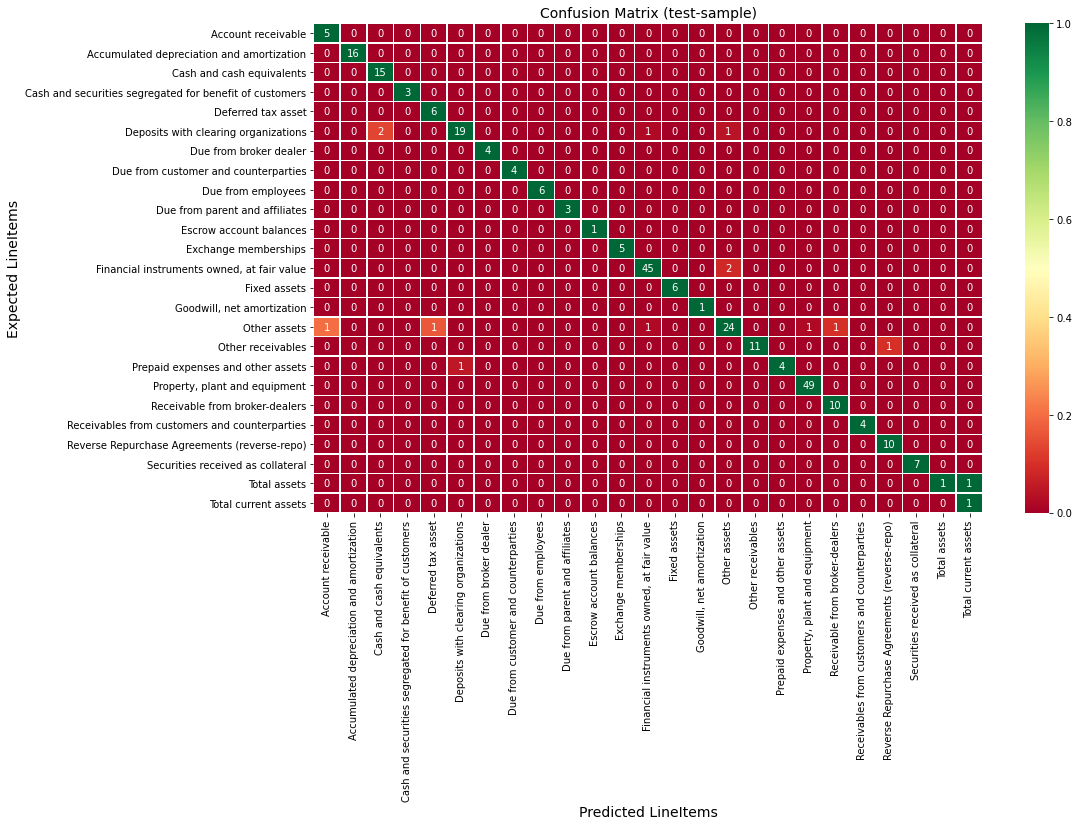

In [173]:
cMatrix(predDf1['Expected LineItems'].values, pred1)

In [111]:
label = 'Account receivable'
print('Type-2 errors')
print(predDf1[predDf1['Expected LineItems'] == label])
print('\nType-1 errors')
print(predDf1[predDf1['Predicted LineItems'] == label])

Type-2 errors
                                      Actual LineItems  Expected LineItems  \
85       Accounts Receivable - Related Parties Deposit  Account receivable   
169                       Accounts Receivable [Note 1]  Account receivable   
173  Brokers, customers and others, net of allowanc...  Account receivable   
242              Accounts receivable - related parties  Account receivable   
269                    Accounts receivable - affiliate  Account receivable   

    Predicted LineItems  
85   Account receivable  
169  Account receivable  
173  Account receivable  
242  Account receivable  
269  Account receivable  

Type-1 errors
                                      Actual LineItems  Expected LineItems  \
85       Accounts Receivable - Related Parties Deposit  Account receivable   
149                Others, net of allowance of $12,848        Other assets   
169                       Accounts Receivable [Note 1]  Account receivable   
173  Brokers, customers and others

**Liability & Equity line items classification model**

In [174]:
lpGrid = {'penalty':['l2'], 'loss':['squared_hinge'], 'dual': [True, False], 'fit_intercept': [True, False],
          'multi_class': ['ovr', 'crammer_singer'], 'C': [1, 5, 10], 'class_weight': ['balanced', None]}

In [175]:
mdl2, predDf2, pred2, cv2 = cls_sec(X2, y2, HashingVectorizer(n_features=1000, strip_accents='ascii', norm='l2'), 
                                    LinearSVC(), lpGrid, cvSplits=5)

Cross-validation measures using 5 splits for default LinearSVC classifier
[0.91728283 0.87367369 0.85284699 0.92012283 0.91320875]

Default estimator
 LinearSVC()
Average cross-validation score using base classifier: 89.53999999999999%

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best GridSearchCV estimator
 LinearSVC(C=5)
Best GridSearchCV score: 92.02%

Percision score from prediction using a micro average: 92.78999999999999%
1-Recall measures type-2 error (e.g. Expectation = Accounts payable, Prediction = Income tax payable)
1-Percision measures type-1 error (e.g. Expectation = Income tax payable, Prediction = Accounts payable)

                                               precision    recall  f1-score   support

                            Accounts payable       0.85      0.94      0.89        18
                         Accrued liabilities       0.89      0.89      0.89         9
                  Additional Paid-in capital       1.00      0.75      0.86       

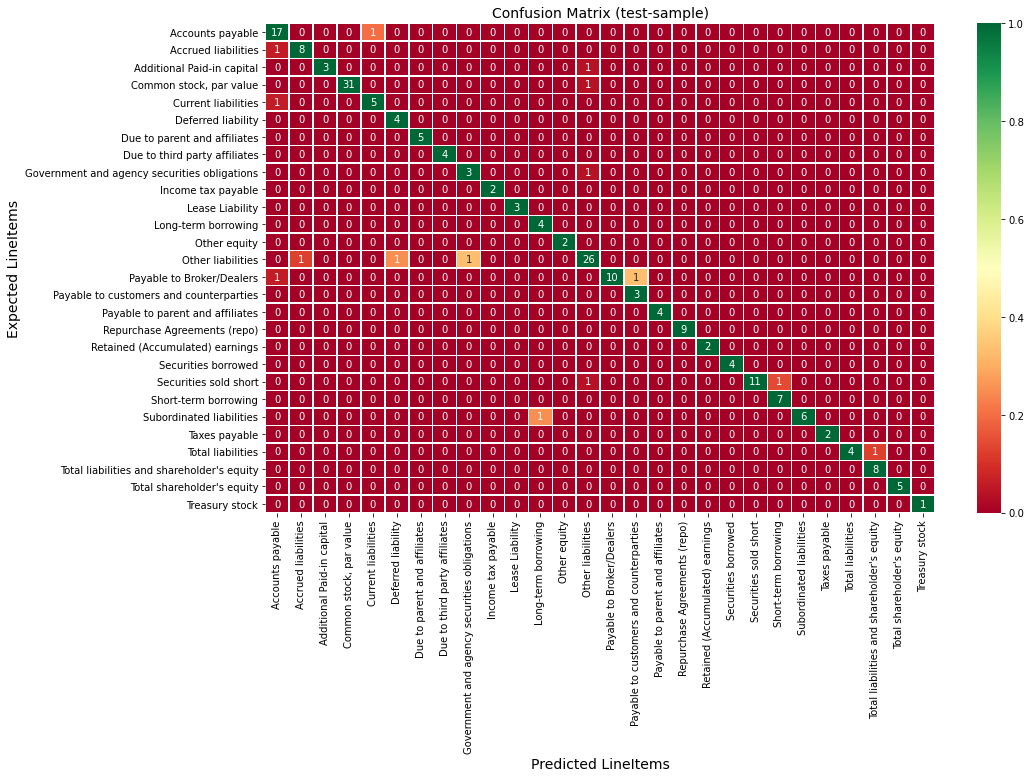

In [177]:
cMatrix(predDf2['Expected LineItems'].values, pred2)

In [180]:
mdl2.predict(HashingVectorizer(n_features=1000).fit_transform(["Total Liabilities"]))

array(['Total liabilities'], dtype=object)

In [165]:
label = "Other equity"
print('Type-2 errors')
print(predDf2[predDf2['Expected LineItems'] == label])
print('\nType-1 errors')
print(predDf2[predDf2['Predicted LineItems'] == label])

Type-2 errors
            Actual LineItems Expected LineItems Predicted LineItems
166  Total partners' capital       Other equity        Other equity

Type-1 errors
            Actual LineItems Expected LineItems Predicted LineItems
54             Contributions  Other liabilities        Other equity
166  Total partners' capital       Other equity        Other equity


**Saving trained model to joblib for export, binary for model strictly**

In [181]:
# for storing model persistence https://scikit-learn.org/stable/modules/model_persistence.html
# dump asset & liability model classifiers ()
dump(mdl1, 'asset_svc_mdl_v1.joblib') 
dump(mdl2, 'liability_svc_mdl_v1.joblib') 

['liability_svc_mdl_v1.joblib']